In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import gc 

plt.style.use("ggplot")

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import FunctionTransformer

def fit_predict_sk(data):
    tfidf = TfidfVectorizer(max_features=2**10)

    train, test = train_test_split(data)

    pipeline = make_pipeline(tfidf, TruncatedSVD(5), RandomForestClassifier(100))

    pipeline.fit(train["STREET"].values, train["country"])
    y_pred = pipeline.predict(test["STREET"].values)

#    print(classification_report(test["country"], y_pred))
    print(accuracy_score(test["country"], y_pred))

In [7]:
import time

MAX_ROWS = 58373613
all_lengths = np.logspace(3, np.log10(MAX_ROWS), 6)
accuracies_sk = []
durations_sk = dict()
print(all_lengths)

[1.00000000e+03 8.97931723e+03 8.06281379e+04 7.23985628e+05
 6.50089662e+06 5.83736130e+07]


In [8]:
for nrows in all_lengths:
    nrows = int(nrows)
    df = (pd.read_csv("data/shuffled_with_txt.csv", nrows=nrows)
          [['STREET', 'country']]
          .dropna())
    
    start = time.time()
    accuracy = fit_predict_sk(df)
    end = time.time()
    
    accuracies_sk.append(accuracy)
    duration = end - start

    print(nrows, ':', duration / 60)
    durations_sk[nrows] = duration
    gc.collect()

0.8425531914893617
1000 : 0.004956173896789551
0.9276473406804024
8979 : 0.009261186917622883
0.9408832672312145
80628 : 0.06250107288360596
0.9487485741927393
723985 : 1.049382734298706
0.9502522694962973
6500896 : 26.8925208290418


MemoryError: Unable to allocate 4.53 GiB for an array with shape (40556814, 15) and data type float64

In [9]:
pd.Series(durations_sk)

1000          0.297370
8979          0.555671
80628         3.750064
723985       62.962964
6500896    1613.551250
dtype: float64

# Spark

In [14]:
import findspark
findspark.init("/home/horace/spark-3.0.0-bin-hadoop2.7")

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.feature import PCA
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

def fit_predict(df):
    label_indexer = StringIndexer(inputCol="country", outputCol="label").fit(df)

    pipeline = Pipeline(stages=[
        label_indexer,
        Tokenizer(inputCol="STREET", outputCol="words"),
        HashingTF(inputCol="words", outputCol="rawFeatures", 
                          numFeatures=20),
        IDF(inputCol="rawFeatures", outputCol="tfidf_features"),
        PCA(k=2, inputCol='tfidf_features', outputCol='pca_features'),
        RandomForestClassifier(featuresCol='pca_features'),
        IndexToString(inputCol="prediction", outputCol="predictedLabel", 
                      labels=label_indexer.labels)
    ])

    model = pipeline.fit(df)
    predictions = model.transform(df)
    evaluator = MulticlassClassificationEvaluator(
        labelCol='label', predictionCol='prediction', metricName='accuracy'
    )
    accuracy = evaluator.evaluate(predictions)
    print("accuracy: ", accuracy)
    return accuracy

In [17]:
import time

MAX_ROWS = 58373613
all_lengths = np.logspace(3, np.log10(MAX_ROWS), 6)
accuracies = []
durations = dict()

In [18]:
for nrows in all_lengths:
    nrows = int(nrows)
    df = (spark
          .read
          .option("header","true")
          .csv("data/shuffled_with_txt.csv")
          .limit(nrows)
          .select('STREET', 'country')
          .dropna())
    
    start = time.time()
    accuracy = fit_predict(df)
    end = time.time()
    
    accuracies.append(accuracy)
    duration = end - start

    print(nrows, ':', duration / 60)
    durations[nrows] = duration
    gc.collect()

accuracy:  0.5479744136460555
1000 : 0.10301299889882405
accuracy:  0.5235413921169282
8979 : 0.05896434783935547
accuracy:  0.5401704362739843
80628 : 0.1892098347345988
accuracy:  0.5372561197737818
723985 : 1.5697023431460062
accuracy:  0.5269031138136676
6500896 : 13.553903114795684
accuracy:  0.5197611217641711
58373613 : 70.67008240620295


In [38]:
durations

{1000: 308.2979419231415,
 8979: 310.13945508003235,
 80628: 314.2683756351471,
 723985: 550.6794626712799,
 6500896: 1178.799343585968,
 58373613: 6514.36515879631}

In [29]:
pd.Series(durations).rename("spark").div(60).to_csv("txt_spark.csv", header=True)

# Comparaison

In [42]:
comp = pd.DataFrame({"spark": durations, "sklearn": durations_sk}).div(60)
comp

,spark,sklearn
1000,5.138299,0.004885
8979,5.168991,0.005278
80628,5.237806,0.006258
723985,9.177991,0.004642
6500896,19.646656,0.004860
58373613,108.572753,0.007280


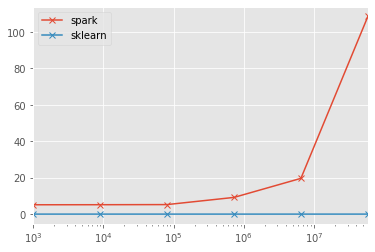

In [47]:
comp.plot(logx=True, marker="x")